In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
library(ggsci)
library(rstatix)
library(ggpubr)
library(ggplot2) 
library(GGally) 
library(pheatmap)


Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘reshape2’ was built under R version 4.3.3”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Warning message:
“package ‘ggsci’ was built under R version 4.3.3”
Warning message:
“package ‘rstatix’ was built under R version 4.3.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘GGally’ was built under R version 4.3.3”
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“package ‘pheatmap’ was built under R version 4.3.3”


In [2]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [3]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read composite score

In [4]:
df<-read.csv('04_Composite_Score/RA_dataset_followup/RA_CompositeScore_Up.csv') 

In [5]:
df<-df%>% filter(celltype %in% c("Core naive CD4 T cell","CM CD4 T cell","Core naive CD8 T cell","CM CD8 T cell"))

In [6]:
df<-df%>% mutate(Group=case_when(Group=="Control (HC1)"~"Healthy\nControl",
                             Group=="ACPA+ At-risk (ARI)"~"pre-RA"))
df$Group<-factor(df$Group,levels=c("Healthy\nControl","pre-RA"))

In [7]:
celltype_order<-c("Core naive CD4 T cell","Core naive CD8 T cell","CM CD8 T cell","CM CD4 T cell")
df$celltype<-factor(df$celltype,levels=celltype_order)

In [8]:
celltype_order_wrapped <- str_wrap(celltype_order, width = 16)


In [9]:
df$celltype <- gsub(" cell", '', df$celltype)
names(color_vector)<-str_wrap(names(color_vector), width = 16)
df$celltype_wrapped <- str_wrap(df$celltype, width = 16)
strip_colors <- setNames(
  color_vector[ unique(df$celltype_wrapped) ],
  unique(df$celltype_wrapped)
)

In [10]:
celltype_order<-c("Core naive CD4 T","CM CD4 T","Core naive CD8 T","CM CD8 T")
df$celltype_wrapped<-factor(df$celltype_wrapped,levels=celltype_order)

In [12]:
table(df$Group)/4


Healthy\nControl           pre-RA 
               6               23 

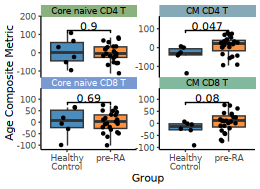

In [11]:
options(repr.plot.width = 55/25.4, repr.plot.height =  40/25.4)
group_levels <- levels(factor(df$Group))
my_comparisons <- combn(group_levels, 2, simplify = FALSE)
p <- ggplot(df  ,
              aes(x = Group, y = composite_score_sum_scaled_mean)) +
    geom_boxplot( lwd=0.3, outlier.shape = NA,aes(fill = `Group`))+
    geom_point(aes(y = composite_score_sum_scaled_mean), 
               position = position_jitter(width = 0.2), color="black", size=1, stroke=0) +
    facet_wrap(~ celltype_wrapped, scales = 'free_y', ncol = 2)+
     stat_compare_means(method = "wilcox.test", 
                        comparisons = my_comparisons, 
                        group.by = "celltype",size=2.2)   +

    theme_classic(base_size = 6) +
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.1, 0.35)))+
ylab('Age Composite Metric')+ 
theme(
  axis.line = element_line(colour = "black"),
  legend.position = "none",
  legend.title = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  strip.background = element_rect(linewidth = 0),
  axis.title.x = element_text(margin = margin(t = 2)),
  panel.spacing = unit(-0.1, "mm"),
  strip.text = element_text(margin = margin(b = 1, t = 1))
) + 
        scale_fill_manual( values = c('#4C8CBD', 
                                       '#FF913D'))

plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))

pal <- color_vector[celltype_order_wrapped]
text_color <- sapply(color_vector[celltype_order_wrapped], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjustcolor(pal[i], alpha.f = 0.8)
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureJ.pdf',plot,width = 55/25.4, height =  40/25.4)

In [12]:
df$RNA_Age_Metric_Up<-df$composite_score_sum_scaled_mean
write.csv(df %>% select(Group,pbmc_sample_id,celltype,RNA_Age_Metric_Up),
          "/home//workspace/Source_Data/Fig2j.csv", row.names=FALSE)